# CNN 기본
## Convolution 및 Pooling 구현

In [1]:
# 필요한 모듈
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img

(429, 640, 3)
(1, 429, 640, 3)
(3, 3, 1, 1)


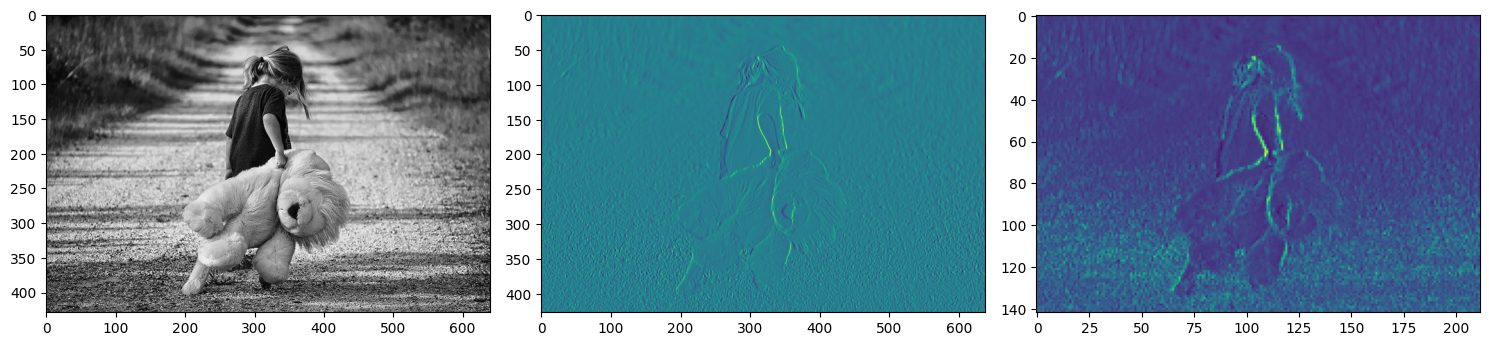

In [9]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ori_image = img.imread('./teddy_bear.jpg')
ax1.imshow(ori_image)
print(ori_image.shape)

# convolution 연산을 수행하려면 입력 이미지가 4차원이어야 한다
# 입력 이미지 형태:
# (이미지 개수, height, width, color)
# (429, 640, 3) -> (1, 429, 640, 3)

input_image = ori_image.reshape((1, ) + ori_image.shape)
print(input_image.shape)
input_image = input_image.astype(np.float32)

channel_1_input_image = input_image[:,:,:,0:1]

# filter 준비
# filter의 형태:
# (filter_height, filter_width, filter_channel, filter_number)
# (3, 3, 1, 1)
weight = np.array([[[[-1]], [[0]], [[1]]],
                   [[[-1]], [[0]], [[1]]],
                   [[[-1]], [[0]], [[1]]]])
print(weight.shape)

conv2d = tf.nn.conv2d(channel_1_input_image,
                      weight,
                      strides=[1,1,1,1],
                      padding='VALID')
# conv2d: 4차원
# 첫 번째 차원: 이미지 개수

conv2d_result = conv2d.numpy()[0,:,:,:]

ax2.imshow(conv2d_result)

# pooling 처리
pool = tf.nn.max_pool(conv2d,
                      ksize=[1,3,3,1],
                      strides=[1,3,3,1],
                      padding='VALID').numpy()

pool_img = pool[0,:,:,:]

ax3.imshow(pool_img)

fig.tight_layout()
plt.show()



## 이미지 학습

### 숫자 MNIST 예제 이용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
# Raw Data Loading
df = pd.read_csv('/content/drive/MyDrive/KCC 3기 Colab Home/data/mnist/train.csv')
print(df.shape)
df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 데이터 전처리
# 1. 결측치 (없음)
# 2. 이상치 (없음)

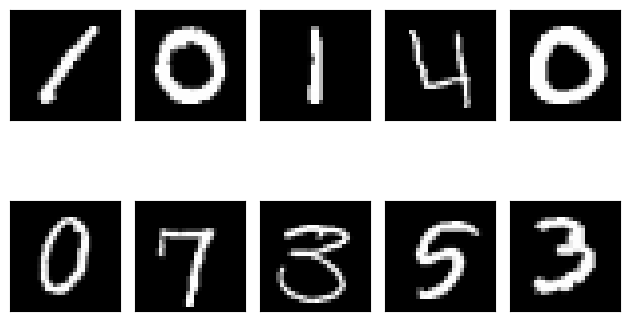

In [15]:
# 이미지 확인
img_data = df.drop('label', axis=1, inplace=False).values

fig = plt.figure()
fig_arr = []

for n in range(10):
  fig_arr.append(fig.add_subplot(2,5,n+1))
  fig_arr[n].grid(False)
  fig_arr[n].set_xticks([])
  fig_arr[n].set_yticks([])
  fig_arr[n].imshow(img_data[n].reshape(28,28), cmap='gray')

plt.tight_layout()
plt.show()

In [13]:
# data 분리
# train, test 분리

x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(img_data,
                 df['label'].values,
                 test_size=0.3,
                 random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

In [16]:
# tensorflow 2.x 모델 구현

model = Sequential()

# 모델 생성 후 layer 세우기
# Feature Extraction (4차원)

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 activation='relu',
                 input_shape=(28,28,1)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [17]:
# model 설정

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callback (ModelCheckpoint, EarlyStopping)

# 학습
model_result = model.fit(x_data_train_norm.reshape(-1,28,28,1),
                         t_data_train,
                         epochs=200,
                         batch_size=100,
                         verbose=1,
                         validation_split=0.3)

Epoch 1/200
206/206 [==============================] - 12s 12ms/step - loss: 0.4921 - accuracy: 0.8419 - val_loss: 0.1229 - val_accuracy: 0.9630
Epoch 2/200
206/206 [==============================] - 1s 5ms/step - loss: 0.1281 - accuracy: 0.9601 - val_loss: 0.0774 - val_accuracy: 0.9761
Epoch 3/200
206/206 [==============================] - 1s 5ms/step - loss: 0.0914 - accuracy: 0.9711 - val_loss: 0.0616 - val_accuracy: 0.9805
Epoch 4/200
206/206 [==============================] - 1s 5ms/step - loss: 0.0740 - accuracy: 0.9770 - val_loss: 0.0511 - val_accuracy: 0.9846
Epoch 5/200
206/206 [==============================] - 1s 5ms/step - loss: 0.0597 - accuracy: 0.9811 - val_loss: 0.0511 - val_accuracy: 0.9846
Epoch 6/200
206/206 [==============================] - 1s 6ms/step - loss: 0.0523 - accuracy: 0.9828 - val_loss: 0.0512 - val_accuracy: 0.9854
Epoch 7/200
206/206 [==============================] - 1s 5ms/step - loss: 0.0440 - accuracy: 0.9862 - val_loss: 0.0451 - val_accuracy: 0.98

In [18]:
# model 평가

model.evaluate(x_data_test_norm.reshape(-1,28,28,1), t_data_test)

394/394 [==============================] - 2s 6ms/step - loss: 0.0737 - accuracy: 0.9913


[0.07367536425590515, 0.9913492202758789]

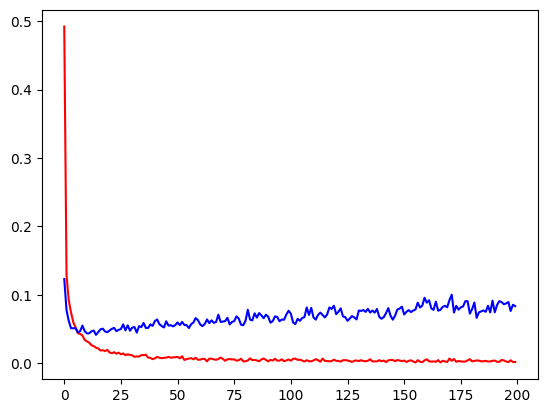

In [19]:
# History 객체를 이용해서 학습 진행을 그래프로 확인

plt.plot(model_result.history['loss'], color='r')
plt.plot(model_result.history['val_loss'], color='b')
plt.show()

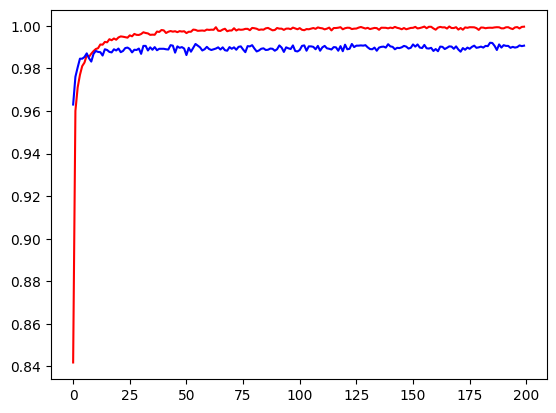

In [20]:
plt.plot(model_result.history['accuracy'], color='r')
plt.plot(model_result.history['val_accuracy'], color='b')
plt.show()

### Fashion MNIST 예제 이용